<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/transfer_learning_and_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning and Fine Tunning

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively server as a generic model of the visual world. You can then take advantage of these leaned feature maps without having to start from scratch by training a large model on a large dataset.

Transfer learning approached contained on this notebook:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously from the dataset.

 You don't need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

2. Fine-Tunning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classfier layers and the last layers of the base model. This allow us to "fine-tune" the higher order feature representations in the base model in order to make them more relevant for the specific task.

Plan of attack:

1. Examine and understand the data
2. Build an `input pipeline`, in this case using Keras ImageDataGenerator
3. Compose the model
  - Load in the pretrained base model (and pretrained weights)
  - Stack the classfication layers on top
4. Train the model 
5. Evaluate model




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

We will use a dataset containing several thousand images of cats and cats. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `.image_dataset_from_directory` utility.

In [7]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, 
                                      extract=True)

68608000/68606236 [==============================] - 2s 0us/step


In [9]:
print(f'path_to_zip -> {path_to_zip}')
print(f'os.path.dirname(path_to_zip) -> {os.path.dirname(path_to_zip)}')

path_to_zip -> /root/.keras/datasets/cats_and_dogs.zip
os.path.dirname(path_to_zip) -> /root/.keras/datasets


In [11]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

print(f'train_dir -> {train_dir}')
print(f'validation_dir -> {validation_dir}')

train_dir -> /root/.keras/datasets/cats_and_dogs_filtered/train
validation_dir -> /root/.keras/datasets/cats_and_dogs_filtered/validation


In [12]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [13]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

In [14]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

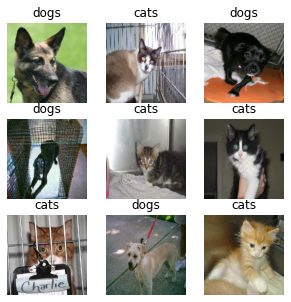

In [23]:
plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')